Original shape: (172010, 6)
After deduplication: (172010, 6)

Classification Report:
              precision    recall  f1-score   support

   Channel 0       0.89      0.74      0.81      3637
   Channel 1       0.94      0.98      0.96     27273
   Channel 2       0.88      0.73      0.80      3492

    accuracy                           0.93     34402
   macro avg       0.90      0.82      0.86     34402
weighted avg       0.93      0.93      0.93     34402


Confusion Matrix:


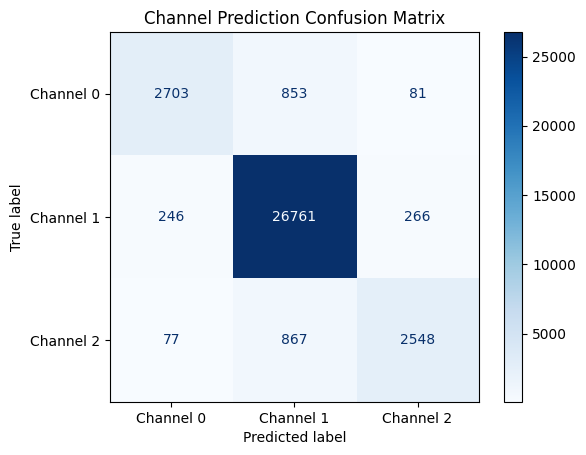

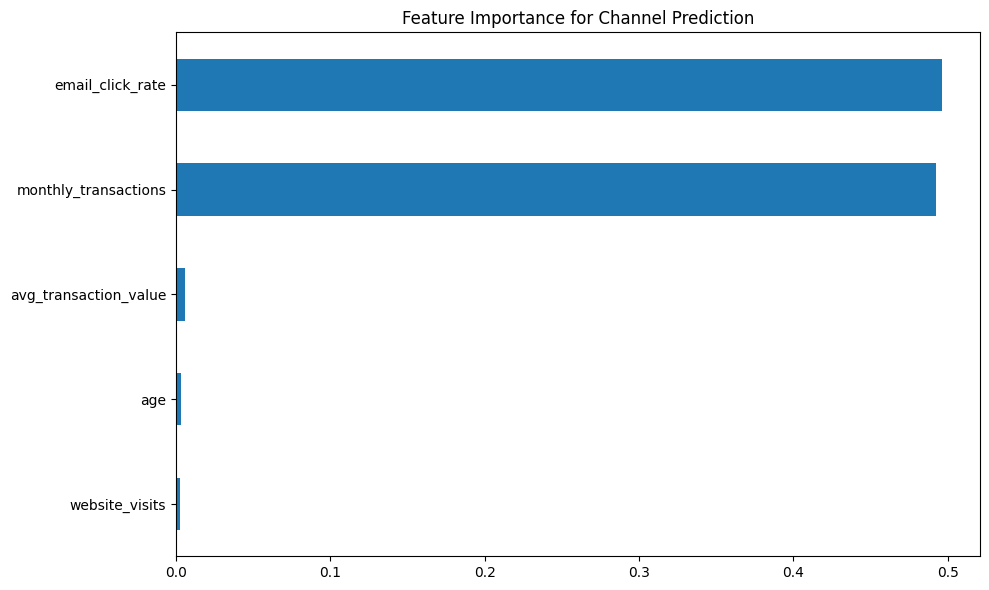

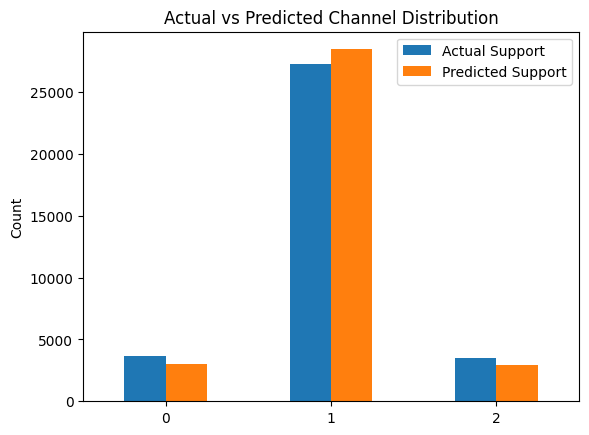

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# 1. Create synthetic dataset for 3-channel classification
np.random.seed(42)
n = 172010  # Total samples matching your support (22664 + 102476 + 46870)

# Feature generation with class-specific patterns
age = np.random.randint(18, 65, size=n)
monthly_transactions = np.random.randint(0, 50, size=n)
avg_transaction_value = np.random.uniform(20, 500, size=n)
website_visits = np.random.randint(0, 30, size=n)
email_click_rate = np.random.uniform(0, 1, size=n)

# Create channel classes based on patterns (0, 1, 2)
channel = np.zeros(n, dtype=int)

# Class 0 pattern (low activity)
class_0_mask = (monthly_transactions < 15) & (email_click_rate < 0.3)
channel[class_0_mask] = 0

# Class 2 pattern (high activity)
class_2_mask = (monthly_transactions > 35) & (email_click_rate > 0.7)
channel[class_2_mask] = 2

# Class 1 pattern (medium activity) - everything else
channel[~class_0_mask & ~class_2_mask] = 1

# Add noise to create realistic overlap
noise_mask = np.random.rand(n) < 0.15
channel[noise_mask] = np.random.choice([0, 1, 2], size=np.sum(noise_mask), p=[0.2, 0.6, 0.2])

# Create DataFrame
data = pd.DataFrame({
    "age": age,
    "monthly_transactions": monthly_transactions,
    "avg_transaction_value": avg_transaction_value,
    "website_visits": website_visits,
    "email_click_rate": email_click_rate,
    "channel": channel  # Target variable
})

# 2. Data Cleaning
print("Original shape:", data.shape)
data.drop_duplicates(inplace=True)
print("After deduplication:", data.shape)

# Introduce missing values
for col in ["age", "monthly_transactions", "avg_transaction_value"]:
    data.loc[np.random.choice(data.index, 500, replace=False), col] = np.nan

# Add outlier
data.loc[0, "avg_transaction_value"] = 5000

# Imputation
imputer = SimpleImputer(strategy="median")
data[["age", "monthly_transactions", "avg_transaction_value"]] = imputer.fit_transform(
    data[["age", "monthly_transactions", "avg_transaction_value"]]
)

# Handle outliers (cap method)
for col in ["age", "monthly_transactions", "avg_transaction_value"]:
    q1 = data[col].quantile(0.05)
    q3 = data[col].quantile(0.95)
    iqr = q3 - q1
    lower_bound = q1 - 3 * iqr
    upper_bound = q3 + 3 * iqr
    data[col] = np.clip(data[col], lower_bound, upper_bound)

# 3. Train-Test Split
X = data.drop("channel", axis=1)
y = data["channel"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Random Forest Classifier - optimized for multi-class
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    min_samples_split=10,
    class_weight='balanced',
    random_state=42
)
clf.fit(X_train, y_train)

# 5. Evaluation
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

# Classification report with target names
target_names = ['Channel 0', 'Channel 1', 'Channel 2']
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names, digits=2))

# Confusion matrix visualization
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues', values_format='d')
plt.title('Channel Prediction Confusion Matrix')
plt.show()

# Feature Importance
feature_importances = pd.Series(clf.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
feature_importances.sort_values().plot(kind='barh', title='Feature Importance for Channel Prediction')
plt.tight_layout()
plt.show()

# Support comparison
support_comparison = pd.DataFrame({
    'Actual Support': y_test.value_counts().sort_index(),
    'Predicted Support': pd.Series(y_pred).value_counts().sort_index()
})
support_comparison.plot(kind='bar', rot=0)
plt.title('Actual vs Predicted Channel Distribution')
plt.ylabel('Count')
plt.show()

Sample dataset:
   Customer_ID  Age  Annual_Income  Satisfaction_Score  Loan_Amount  \
0            1   59         689570                   1       461927   
1            2   49         224538                   9       839852   
2            3   35        1094498                   6       933184   
3            4   28         401664                   3       181373   
4            5   41         691234                   4       488452   

          Loan_Type  
0     Personal Loan  
1     Personal Loan  
2  Two-Wheeler Loan  
3     Used Car Loan  
4     Used Car Loan  

Cluster Summary (mean values):
               Age  Annual_Income  Satisfaction_Score    Loan_Amount
Cluster                                                             
0        46.892857   6.507775e+05            7.535714  627969.000000
1        33.000000   1.194417e+06            5.548387  353120.709677
2        39.195122   6.331294e+05            2.487805  453890.317073


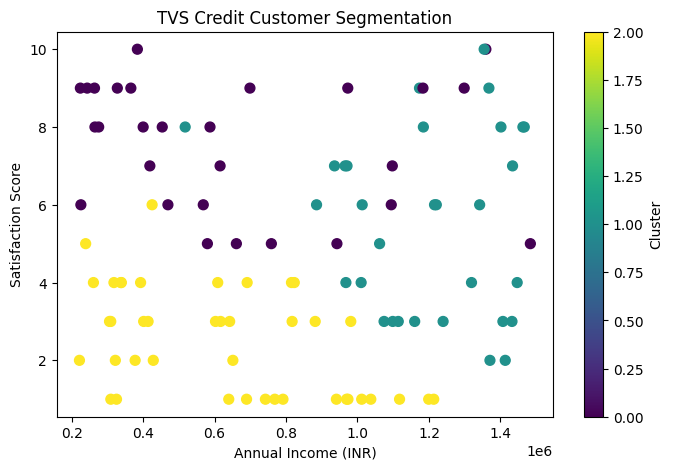

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# ---------------------------
# 1. CREATE SYNTHETIC DATASET
# ---------------------------
np.random.seed(42)

n_samples = 100
data = pd.DataFrame({
    "Customer_ID": range(1, n_samples + 1),
    "Age": np.random.randint(21, 60, n_samples),
    "Annual_Income": np.random.randint(200000, 1500000, n_samples),  # in INR
    "Satisfaction_Score": np.random.randint(1, 11, n_samples),  # 1 to 10
    "Loan_Amount": np.random.randint(50000, 1000000, n_samples),  # INR
    "Loan_Type": np.random.choice(["Two-Wheeler Loan", "Used Car Loan", "Personal Loan"], n_samples)
})

print("Sample dataset:")
print(data.head())

# ---------------------------
# 2. FEATURE SELECTION & SCALING
# ---------------------------
features = ["Age", "Annual_Income", "Satisfaction_Score", "Loan_Amount"]
X = data[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------------
# 3. K-MEANS CLUSTERING
# ---------------------------
kmeans = KMeans(n_clusters=3, random_state=42)
data["Cluster"] = kmeans.fit_predict(X_scaled)

# ---------------------------
# 4. ANALYZE SEGMENTS
# ---------------------------
cluster_summary = data.groupby("Cluster")[features].mean()
print("\nCluster Summary (mean values):")
print(cluster_summary)

# ---------------------------
# 5. VISUALIZE CLUSTERS
# ---------------------------
plt.figure(figsize=(8, 5))
plt.scatter(data["Annual_Income"], data["Satisfaction_Score"],
            c=data["Cluster"], cmap="viridis", s=50)
plt.xlabel("Annual Income (INR)")
plt.ylabel("Satisfaction Score")
plt.title("TVS Credit Customer Segmentation")
plt.colorbar(label="Cluster")
plt.show()


In [ ]:
# Install dependencies first (uncomment if running locally)
!pip install transformers torch matplotlib pandas seaborn

import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Synthetic dataset: Customer conversations
data = {
    "conversation": [
        "I need help with my EMI payment",
        "My loan approval is taking too long!",
        "Can I get a top-up loan?",
        "The customer service is excellent",
        "I am very disappointed with your service",
        "How do I change my registered phone number?"
    ],
    "intent": ["Payment Help", "Loan Delay", "Loan Inquiry", "Feedback Positive", "Feedback Negative", "Account Update"],
    "priority": ["High", "High", "Medium", "Low", "High", "Medium"]
}

df = pd.DataFrame(data)

# 2. Load pretrained sentiment model (BERT)
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"  # 1-5 star sentiment
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def get_sentiment(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        output = model(**tokens)
    scores = torch.nn.functional.softmax(output.logits, dim=-1)
    predicted_label = torch.argmax(scores) + 1  # Labels are 1 to 5
    return int(predicted_label)

# 3. Apply sentiment detection
df["sentiment_score"] = df["conversation"].apply(get_sentiment)
df["sentiment_label"] = df["sentiment_score"].map({
    1: "Very Negative", 2: "Negative", 3: "Neutral", 4: "Positive", 5: "Very Positive"
})

# 4. Visualization
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="sentiment_label", hue="priority", palette="coolwarm")
plt.title("Customer Conversation Sentiment by Priority")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.legend(title="Priority")
plt.show()

print(df)


In [ ]:
"""
Customer Preference Prediction (Recommendation Systems)
Approaches:
 - Item-based Collaborative Filtering (cosine similarity)
 - Matrix Factorization via truncated SVD (latent-factor recommendations)

Usage:
 - Replace synthetic data generation with your real user-item interaction table:
   columns: user_id, item_id, interaction (e.g., clicks, purchases, rating, 1 for interacted)
 - Run and call recommend_for_user(user_id, k=10, method='item'|'svd')
"""

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from scipy.sparse import csr_matrix

# -------------------------
# 1) Synthetic dataset (replace with real data)
# -------------------------
np.random.seed(42)
n_users = 300
n_items = 120

# Simulate implicit interactions: 1 = interacted (view/click/purchase), 0 = no interaction
rows = []
for u in range(n_users):
    # each user interacts with 5-25 items
    n = np.random.randint(5, 26)
    items = np.random.choice(n_items, n, replace=False)
    for it in items:
        # optional: weight interactions by recency or intensity
        w = np.random.choice([1, 1, 1, 2])  # mostly 1, some 2s
        rows.append((u, it, w))

interactions = pd.DataFrame(rows, columns=["user_id", "item_id", "interaction"])
print("Interactions shape:", interactions.shape)
print(interactions.head())

# -------------------------
# 2) Create user-item matrix (CSR)
# -------------------------
def build_user_item_matrix(df, users_col="user_id", items_col="item_id", value_col="interaction"):
    users = df[users_col].unique()
    items = df[items_col].unique()
    user_to_idx = {u: i for i, u in enumerate(users)}
    item_to_idx = {i: j for j, i in enumerate(items)}
    rows = df[users_col].map(user_to_idx)
    cols = df[items_col].map(item_to_idx)
    vals = df[value_col].astype(float)
    mat = csr_matrix((vals, (rows, cols)), shape=(len(users), len(items)))
    return mat, users, items, user_to_idx, item_to_idx

UI_matrix, users, items, user_to_idx, item_to_idx = build_user_item_matrix(interactions)

# -------------------------
# 3) ITEM-BASED Collaborative Filtering (cosine similarity)
# -------------------------
# Compute item-item similarity using cosine on item vectors (items as columns)
item_vectors = UI_matrix.T.tocsr()  # items x users
# Convert to dense if small; keep sparse route - compute similarity via cosine_similarity (works on sparse)
item_sim = cosine_similarity(item_vectors, dense_output=False)  # yields item x item matrix (scipy sparse)

def recommend_item_cf(user_id, k=10):
    """
    Recommend top-k items for user using item-based CF.
    Steps:
      - for each item user has interacted with, get its similarity vector
      - score candidate items by weighted sum of similarities * interaction weight
      - filter out already-seen items and return top-k
    """
    if user_id not in user_to_idx:
        return []
    uidx = user_to_idx[user_id]
    user_row = UI_matrix.getrow(uidx).toarray().ravel()  # shape (n_items,)
    seen_mask = user_row > 0
    # weighted sum of item similarities
    # item_sim is item x item; convert to array if small, else use matrix multiplications
    scores = item_sim.dot(user_row)  # shape (n_items,)
    scores = np.array(scores).ravel()
    scores[seen_mask] = -np.inf  # exclude seen items
    top_idx = np.argpartition(-scores, k)[:k]
    top_items = [items[i] for i in top_idx[np.argsort(-scores[top_idx])]]
    return top_items

# -------------------------
# 4) MATRIX FACTORIZATION via Truncated SVD (approx implicit MF)
# -------------------------
n_components = 20
svd = TruncatedSVD(n_components=n_components, random_state=42)
# Fit on user-item sparse matrix (dense factorization will produce user & item latent vectors)
user_factors = svd.fit_transform(UI_matrix)          # users x n_components
item_factors = svd.components_.T                     # items x n_components

# Normalize for cosine-like similarity in latent space
user_factors = normalize(user_factors)
item_factors = normalize(item_factors)

def recommend_svd(user_id, k=10):
    if user_id not in user_to_idx:
        return []
    uidx = user_to_idx[user_id]
    user_vec = user_factors[uidx]           # latent vector for user
    scores = item_factors.dot(user_vec)     # similarity scores
    # remove seen items
    seen_mask = UI_matrix.getrow(uidx).toarray().ravel() > 0
    scores[seen_mask] = -np.inf
    top_idx = np.argpartition(-scores, k)[:k]
    top_items = [items[i] for i in top_idx[np.argsort(-scores[top_idx])]]
    return top_items

# -------------------------
# 5) Simple evaluation: Precision@K on held-out interactions (basic)
# -------------------------
from sklearn.model_selection import train_test_split

# Create train/test by splitting interactions per user (leave-one-out style)
def train_test_split_interactions(df, test_size_per_user=0.2):
    train_rows = []
    test_rows = []
    for u, g in df.groupby("user_id"):
        n = len(g)
        if n <= 1:
            train_rows.append(g)
            continue
        n_test = max(1, int(np.ceil(test_size_per_user*n)))
        test_idx = np.random.choice(g.index, n_test, replace=False)
        test_rows.append(g.loc[test_idx])
        train_rows.append(g.drop(index=test_idx))
    train = pd.concat(train_rows).reset_index(drop=True)
    test = pd.concat(test_rows).reset_index(drop=True)
    return train, test

train_df, test_df = train_test_split_interactions(interactions, test_size_per_user=0.25)
UI_train, _, _, user_to_idx_train, item_to_idx_train = build_user_item_matrix(train_df)

# Replace global variables for recommenders to use train matrix
UI_matrix = UI_train
users = train_df["user_id"].unique()
items = train_df["item_id"].unique()
user_to_idx = user_to_idx_train
item_to_idx = item_to_idx_train

# Recompute models on train
item_vectors = UI_matrix.T.tocsr()
item_sim = cosine_similarity(item_vectors, dense_output=False)
svd = TruncatedSVD(n_components=n_components, random_state=42)
user_factors = svd.fit_transform(UI_matrix)
item_factors = svd.components_.T
user_factors = normalize(user_factors)
item_factors = normalize(item_factors)

def precision_at_k(recommender_fn, test_df, k=10, n_users_eval=100):
    # sample some users to evaluate
    users_sample = np.random.choice(test_df["user_id"].unique(), min(n_users_eval, test_df["user_id"].nunique()), replace=False)
    precisions = []
    for u in users_sample:
        true_items = set(test_df[test_df["user_id"] == u]["item_id"].unique())
        recs = recommender_fn(u, k=k)
        if len(recs) == 0:
            continue
        hit = len([r for r in recs if r in true_items])
        precisions.append(hit / k)
    return np.mean(precisions) if len(precisions) else 0.0

print("Precision@10 (item-cf):", precision_at_k(recommend_item_cf, test_df, k=10, n_users_eval=100))
print("Precision@10 (svd):", precision_at_k(recommend_svd, test_df, k=10, n_users_eval=100))

# -------------------------
# 6) Example: get recommendations for a user
# -------------------------
some_user = train_df["user_id"].sample(1).iloc[0]
print("\nUser:", some_user)
print("Item-CF top-10:", recommend_item_cf(some_user, k=10))
print("SVD top-10:", recommend_svd(some_user, k=10))

# -------------------------
# Notes & next steps
# -------------------------
# - For TVS Credit: use interactions such as product views, application starts, approvals, top-ups, payments as signals.
# - Add content signals: customer profile (age, income) and item metadata (loan type, tenure) to create a hybrid model.
# - Use implicit-feedback-aware MF (e.g., Alternating Least Squares / LightFM / implicit library) for production.
# - For evaluation, track business KPIs: conversion uplift, click-through, and revenue-per-recommendation via A/B tests.


In [ ]:
# Automated Workflow Orchestration prototype
# - Combines a rule-based decision tree for quick routing with a Q-learning agent for adaptive step selection.
# - Simulates customer onboarding environment and trains a Q-learning agent to choose actions that maximize conversion.
# - Run in a notebook or Colab. No external data required.

import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

# ---------------------------
# Environment definition
# ---------------------------
# Discrete state represented by (engagement_level, verification_status, days_since_signup_bucket)
# engagement_level: 0(low),1(medium),2(high)
# verification_status: 0(not verified),1(verified)
# days_since_signup_bucket: 0(0-2 days),1(3-7 days),2(8+ days)
engagement_levels = [0,1,2]
verif_status = [0,1]
days_buckets = [0,1,2]

states = [(e,v,d) for e in engagement_levels for v in verif_status for d in days_buckets]
state_to_idx = {s:i for i,s in enumerate(states)}
idx_to_state = {i:s for s,i in state_to_idx.items()}

n_states = len(states)

# Actions: discrete choices for next onboarding step
actions = [
    "send_email",        # 0
    "send_whatsapp",     # 1
    "call_agent",        # 2
    "request_documents", # 3
    "offer_discount"     # 4
]
n_actions = len(actions)

# Simulate customer response probability given state and action (for training environment)
def response_probability(state, action):
    engagement, verif, days = state
    base = 0.05 + 0.15*engagement  # higher engagement -> higher base prob
    # verification increases chance of conversion for docs/offers
    if action == 2:  # call_agent has higher success for low engagement
        prob = base + (0.2 if engagement==0 else 0.1)
    elif action in (0,1):  # email/whatsapp rely on engagement
        prob = base + (0.2 if engagement==2 else 0.05)
    elif action == 3:  # request_documents reduces immediate conversion chance but may lead to future conversion
        prob = base - 0.05 + (0.15 if verif==1 else 0)
    elif action == 4:  # offer_discount can boost conversion if days bucket is small
        prob = base + (0.25 if days==0 else 0.08)
    # small random noise
    prob = max(0.01, min(0.95, prob + np.random.normal(0, 0.02)))
    return prob

# Transition function: how state evolves after action and response
def transition(state, action, responded):
    e,v,d = state
    # days might increase
    d = min(2, d + (0 if responded else 1))  # if responded, days may not increase
    # engagement updates
    if responded:
        e = min(2, e + 1)
    else:
        e = max(0, e - 1)
    # verification can get set to 1 if action was request_documents and responded positively
    if action == 3 and responded:
        v = 1
    return (e,v,d)

# Reward function
def reward_fn(state, action, responded, converted):
    # small negative step cost to encourage faster conversion
    r = -1
    if responded:
        r += 1  # reward for engagement
    if converted:
        r += 20  # big reward on conversion
    # requesting documents has long-term value if it results in verification
    if action == 3 and responded:
        r += 5
    # penalty for long delays (days bucket high)
    if state[2] == 2 and not converted:
        r -= 2
    return r

# ---------------------------
# Simple rule-based decision tree for routing (fast lane)
# ---------------------------
def rule_based_routing(state):
    e,v,d = state
    # If high engagement, prefer digital channels; if low engagement, call agent
    if e == 2:
        return 1  # whatsapp
    if e == 0 and d >= 1:
        return 2  # call agent for low engagement who delayed
    if v == 0 and e >= 1:
        return 3  # request documents to verify
    return 0  # default send email

# ---------------------------
# Q-learning agent
# ---------------------------
Q = np.zeros((n_states, n_actions))
alpha = 0.1      # learning rate
gamma = 0.95     # discount factor
epsilon = 0.2    # exploration rate

def choose_action(state_idx, use_rule=False):
    # optionally use rule-based routing as a warm start / bias
    if use_rule and random.random() < 0.5:
        act = rule_based_routing(idx_to_state[state_idx])
        return act
    if random.random() < epsilon:
        return random.randrange(n_actions)
    return int(np.argmax(Q[state_idx]))

# ---------------------------
# Training loop (simulated episodes)
# ---------------------------
n_episodes = 2000
episode_rewards = []

for ep in range(n_episodes):
    # initialize a random starting state
    state_idx = random.randrange(n_states)
    state = idx_to_state[state_idx]
    total_reward = 0
    done = False
    # simulate up to 10 steps per episode
    for t in range(10):
        action_idx = choose_action(state_idx, use_rule=True)
        prob = response_probability(state, action_idx)
        responded = random.random() < prob
        # determine conversion probability: higher if engagement and responded
        converted_prob = 0.1 + 0.2*state[0] + (0.3 if responded else 0)
        converted = random.random() < min(0.9, converted_prob)
        r = reward_fn(state, action_idx, responded, converted)
        total_reward += r
        next_state = transition(state, action_idx, responded)
        next_idx = state_to_idx[next_state]
        # Q-learning update
        best_next = np.max(Q[next_idx])
        Q[state_idx, action_idx] = Q[state_idx, action_idx] + alpha * (r + gamma * best_next - Q[state_idx, action_idx])
        state_idx = next_idx
        state = next_state
        if converted:
            break
    episode_rewards.append(total_reward)

# ---------------------------
# Results and visualization
# ---------------------------
# Plot episode rewards to show learning progress
plt.figure(figsize=(10,4))
plt.plot(pd.Series(episode_rewards).rolling(50).mean(), label="Rolling mean reward (50 eps)")
plt.title("Q-learning: Rolling Average Episode Reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()

# Display learned policy (best action per state) in a table
policy = [actions[int(np.argmax(Q[i]))] for i in range(n_states)]
policy_df = pd.DataFrame(states, columns=["Engagement","Verified","Days"]).reset_index(drop=True)
policy_df["Best_Action"] = policy
print("\nLearned Policy (sample):")
print(policy_df.head(12))

# Show Q-values for a sample state
sample_state = (1,0,1)  # medium engagement, not verified, 3-7 days
print("\nSample state:", sample_state)
print("Q-values:", Q[state_to_idx[sample_state]])
print("Recommended action:", actions[int(np.argmax(Q[state_to_idx[sample_state]]))])

# Demonstrate a single simulated onboarding run using the learned policy
print("\nSimulated onboarding run (policy-driven):")
state = (0,0,0)  # start: low engagement, not verified, day 0
for step in range(8):
    s_idx = state_to_idx[state]
    action_idx = int(np.argmax(Q[s_idx]))
    action = actions[action_idx]
    prob = response_probability(state, action_idx)
    responded = random.random() < prob
    converted = random.random() < (0.1 + 0.2*state[0] + (0.3 if responded else 0))
    print(f"Step {step+1} | State={state} | Action={action} | Responded={responded} | Converted={converted}")
    state = transition(state, action_idx, responded)
    if converted:
        print("=> Conversion achieved. Stopping simulation.")
        break


In [ ]:
import matplotlib.pyplot as plt

# Sample data: customer channels and their usage counts
channels = ['Website', 'Mobile App', 'Branch Visit', 'Phone Call', 'Social Media', 'Email']
counts = [350, 280, 150, 200, 100, 70]

# Create pie chart
plt.figure(figsize=(8, 6))
plt.pie(counts, labels=channels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Set3.colors)
plt.title('Customer Channels Usage Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data: Number of enquiries for each channel at different times of day
times_of_day = ["Morning", "Afternoon", "Evening", "Night"]
channels = ["Phone", "WhatsApp", "Chatbot", "Email"]

# Example enquiry counts (rows: times, cols: channels)
enquiries = np.array([
    [40, 25, 15, 10],  # Morning
    [35, 40, 20, 15],  # Afternoon
    [20, 30, 35, 10],  # Evening
    [10, 15, 20, 5]    # Night
])

x = np.arange(len(times_of_day))  # label locations
width = 0.2  # width of bars

fig, ax = plt.subplots(figsize=(10, 6))

for i, channel in enumerate(channels):
    ax.bar(x + i*width, enquiries[:, i], width, label=channel)

# Formatting
ax.set_xlabel("Time of Day", fontsize=12)
ax.set_ylabel("Number of Enquiries", fontsize=12)
ax.set_title("Customer Enquiries by Channel and Time of Day", fontsize=14, fontweight='bold')
ax.set_xticks(x + width*(len(channels)-1)/2)
ax.set_xticklabels(times_of_day)
ax.legend(title="Channel")
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [ ]:
# df['Age']

In [ ]:
# df.loc[5] = 'DEVRAJ', '21', 'Kolkata' , 'INDIA'  #ADD A NEW ROW
# print(df)

In [ ]:
# df['Age']

In [ ]:
# df.loc[3] = 12 #if we update the row with a value the entire row must be same to the value
# print(df)

In [ ]:
# df=df.drop(3) #DELETE THE 3rd ROW
# print(df)

In [ ]:
# df=df.drop('City',axis=1) #DELETE THE 3rd coloumn
# print(df)

In [ ]:
# import numpy as np
# df['Age']= df['Age'].apply(np.square) #Apply A SQUARE FUNCTION TO THE AGE COLUMNS EVERY VALUES
# print(df)

In [ ]:
# df['Age']

In [ ]:
# def fun(string):   # Apply the function and update the 'Name' column
#   return string.upper()
# df['Name']=df['Name'].apply(fun) #(fun)
# print(df)

In [ ]:
# def add(row):
#     row['Age'] = row['Age'] + 10
#     return row  #update the age column values

# df = df.apply(add, axis=1)
# print(df)


In [ ]:

# df['Age'] = df['Age'].apply(lambda x: x + 5)

# print(df)


In [ ]:
# list =[1,2,3,4,5]
# dt=pd.DataFrame(list)
# print(dt)

In [ ]:
# list =([1,2,3,4,5],(7,3,2,1,121))
# dt=pd.DataFrame(list)
# print(dt)

In [ ]:
# df.loc[3] = 12 #if we update the row with a value the entire row must be same to the value
# print(df)

In [ ]:
# df=df.drop(3) #DELETE THE 3rd ROW
# print(df)

In [ ]:
# import pandas as pd

# # dictionary
# data = {
#     'Name': ['Alice', 'Bob', 'Charlie'],
#     'Age': [25, 30, 35],
#     'City': ['New York', 'Paris', 'London']
# }
# df = pd.DataFrame(data)

# print(df)


**SIMPLE MATRIX 4X5**

In [ ]:
# import numpy as np

# # Create a 4x5 matrix with random integers between 0 and 9
# matrix = np.random.randint(0, 10, size=(4, 5))

# print(matrix)


In [ ]:
# !pip install scanpy

In [ ]:

# import numpy as np
# import pandas as pd
# import scanpy as sc
# #matrix = np.random.rand(4, 5)

# cell_df = pd.DataFrame({
#     "CellID": ['C1','C2','C3','C4'],
#     "SampleID": ['s1','s2','s3','s4',],
#     "DateCollected": pd.date_range("2025-06-01", periods=4).astype(str) #update date and convert this date to a string
# }, index=[f"Cell{i+1}" for i in range(4)]) #using function and increment rows to 4


# gene_df = pd.DataFrame({
#     "GeneID": [1,2,3,4,5],
#     "GeneName": ['ABC1','badbs','sdasew','daad','dadwwa'],
#     "IsMitochondrial": [i % 2 == 0 for i in range(5)], #it only check this like odd or even number 	0 % 2 == 0 → 0 == 0 (TRUE) , 1%2 ==1 (FALSE)
#     "IsCellCycle": [i % 3 == 0 for i in range(5)]
# }, index=[0,1,2,3,4]
# )

# # reate AnnData
# adata = sc.AnnData(
#     X=matrix,
#     obs=cell_df,
#     var=gene_df
# )

# print(cell_df)

# print(gene_df )
# print(adata)



